In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *

In [0]:
!echo '{"username":"manishdevgan","key":"myKey"}' > ~/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c planet-understanding-the-amazon-from-space
! wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local

/bin/bash: /root/.kaggle/kaggle.json: No such file or directory
--2019-11-02 10:15:30--  https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651745206 (622M) [application/x-sh]
Saving to: ‘Anaconda3-5.2.0-Linux-x86_64.sh’

Anaconda3-5.2.0-Lin 100%[===================>] 621.55M   187MB/s    in 3.3s    

2019-11-02 10:15:38 (187 MB/s) - ‘Anaconda3-5.2.0-Linux-x86_64.sh’ saved [651745206/651745206]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: blas-1.0-mkl ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-8 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libgfortran-ng-7.2.0-hdf63c60_3 ...
insta

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! echo '{"username":"manishdevgan","key":"17103623455df7d2bcc55c33caf554eb"}' > /root/.kaggle/kaggle.json
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path} 
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 595M/600M [00:05<00:00, 110MB/s] 
100% 600M/600M [00:05<00:00, 106MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 47.3MB/s]


In [0]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.4
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

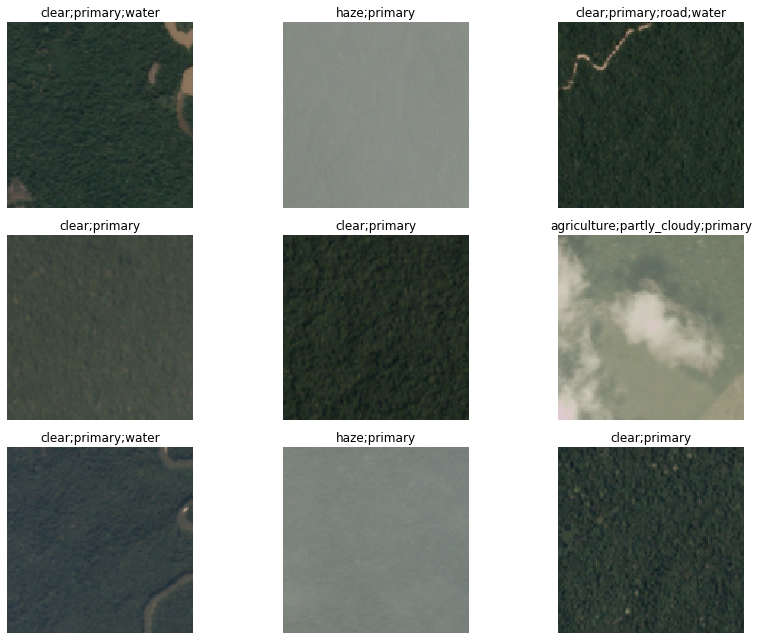

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.0MB/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


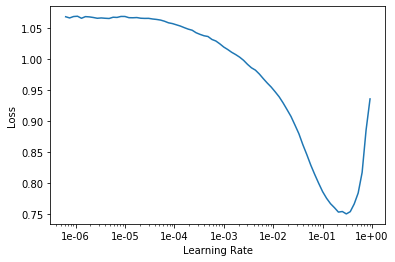

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137788,0.115311,0.939912,0.898396,03:57
1,0.115426,0.099332,0.953406,0.912618,04:16
2,0.101599,0.092013,0.952992,0.920349,04:14
3,0.096028,0.088575,0.956894,0.923846,03:53
4,0.092357,0.086983,0.957076,0.924903,03:54


In [0]:
learn.save('stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


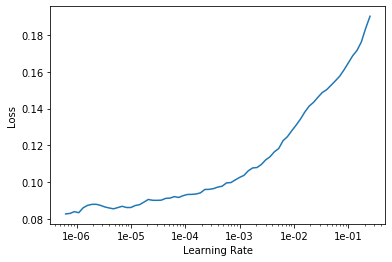

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097274,0.089883,0.953864,0.921141,04:38
1,0.097278,0.090783,0.951037,0.920216,04:41
2,0.091520,0.087235,0.958340,0.924818,04:41
3,0.086285,0.083487,0.958580,0.927525,04:40
4,0.080861,0.082855,0.958747,0.927147,04:46


In [0]:
learn.save('stage-2-rn50')

In [0]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AttributeError: ignored

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084458,0.086857,0.957715,0.924232,10:57
1,0.087623,0.085594,0.961661,0.926143,10:57
2,0.086979,0.083214,0.958842,0.929301,10:57
3,0.082665,0.081652,0.958202,0.928668,10:50
4,0.080196,0.081315,0.958203,0.930127,10:54


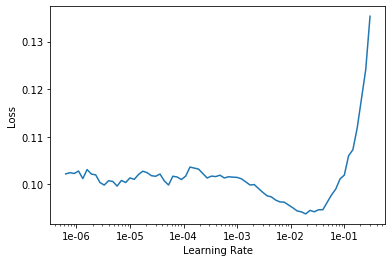

In [0]:
learn.recorder.plot()
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083867,0.083147,0.958689,0.927826,14:41
1,0.086022,0.085420,0.955827,0.926512,14:32
2,0.081518,0.082056,0.956764,0.928875,14:33
3,0.081375,0.081339,0.960811,0.930951,14:27
4,0.073968,0.080749,0.959387,0.930212,14:26


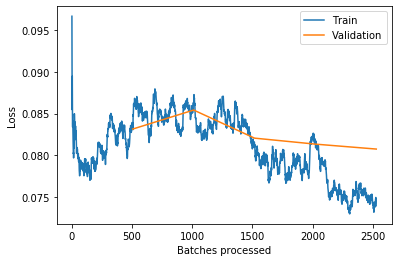

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

100% 601M/603M [00:07<00:00, 50.4MB/s]
100% 603M/603M [00:07<00:00, 81.0MB/s]
 98% 299M/304M [00:03<00:00, 88.4MB/s]
100% 304M/304M [00:03<00:00, 87.5MB/s]


In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['agriculture clear primary road',
 'clear primary',
 'partly_cloudy primary',
 'clear primary',
 'clear primary']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:01<00:00, 1.19MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space